In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def L_train(w, alpha):
    L = w ** 2 - 2 * alpha * w + alpha ** 2
    return L

In [4]:
def L_val(w, alpha):
    L = alpha * w - 2 * alpha + 1
    return L

In [5]:
def optimize_alpha(w, alpha, optim_w, optim_alpha, xi):
    # zero grads
    optim_alpha.zero_grad()
    optim_w.zero_grad()
    
    if xi > 0:
        # compute w_prime
        L_train_w_alpha = L_train(w, alpha)
        L_train_w_alpha.backward()
        grad_w_L_train_w_alpha = w.grad.detach().clone()
        w_prime = w - xi * grad_w_L_train_w_alpha
        w_prime.retain_grad()
    else:
        w_prime = w.detach().clone()
    
    # compute grad_alpha_L_val_w_prime_alpha
    L_val_w_prime_alpha = L_val(w_prime, alpha)
    optim_alpha.zero_grad()
    L_val_w_prime_alpha.backward()
    grad_alpha_L_val_w_prime_alpha = alpha.grad.detach().clone()
    
    if xi > 0:
        # compute w_plus, w_minus
        eps = 0.01 / torch.norm(w_prime.grad, p=2).item()
        w_plus = w + eps * w_prime.grad
        w_minus = w - eps * w_prime.grad
    
        # compute finite-difference grad approximation
        L_train_w_plus_alpha = L_train(w_plus, alpha)
        L_train_w_minus_alpha = L_train(w_minus, alpha)
        L_diff = L_train_w_plus_alpha - L_train_w_minus_alpha
        optim_alpha.zero_grad()
        L_diff.backward()
        grad_finite_diff = alpha.grad.detach().clone() / 2 / eps
    
        grad_alpha = grad_alpha_L_val_w_prime_alpha - xi * grad_finite_diff
    else:
        grad_alpha = grad_alpha_L_val_w_prime_alpha
        
    optim_alpha.zero_grad()
    alpha.grad = grad_alpha
    optim_alpha.step()

In [6]:
def train(num_iter, xi, thr, lr):
    alpha = nn.Parameter(data=torch.Tensor([2]), requires_grad=True)
    w = nn.Parameter(data=torch.Tensor([-2]), requires_grad=True)
    
    optim_alpha = torch.optim.SGD([alpha], lr=lr)
    optim_w = torch.optim.SGD([w], lr=lr)
    
    alpha_history = [alpha.item()]
    w_history = [w.item()]
    
    alpha_prev, w_prev = None, None
    
    for i in tqdm(range(num_iter)):
        if i > 0 and torch.abs(alpha - alpha_prev) < thr and torch.abs(w - w_prev) < thr:
            break
        alpha_prev = alpha.clone()
        w_prev = w.clone()

        # alpha update
        optimize_alpha(w=w, alpha=alpha, optim_w=optim_w, optim_alpha=optim_alpha, xi=xi)

        # update w
        L_train_w_alpha = L_train(w, alpha)
        optim_w.zero_grad()
        L_train_w_alpha.backward()
        optim_w.step()

        alpha_history.append(alpha.item())
        w_history.append(w.item())
        
    return alpha_history, w_history

In [7]:
alpha_star = torch.Tensor([1])
w_star = torch.Tensor([1])
alpha_star, w_star

(tensor([1.]), tensor([1.]))

In [8]:
alpha_history_0, w_history_0 = train(num_iter=10000, xi=0, thr=1e-4, lr=1e-2)

  7%|▋         | 659/10000 [00:00<00:03, 2434.09it/s]


In [9]:
alpha_history_03, w_history_03 = train(num_iter=10000, xi=0.3, thr=1e-4, lr=1e-2)

  4%|▍         | 411/10000 [00:00<00:08, 1113.76it/s]


In [10]:
alpha_history_05, w_history_05 = train(num_iter=10000, xi=0.5, thr=1e-4, lr=1e-2)

  3%|▎         | 296/10000 [00:00<00:08, 1138.00it/s]


In [11]:
alpha_history_07, w_history_07 = train(num_iter=10000, xi=0.7, thr=1e-4, lr=1e-2)

  3%|▎         | 335/10000 [00:00<00:08, 1108.85it/s]


(array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

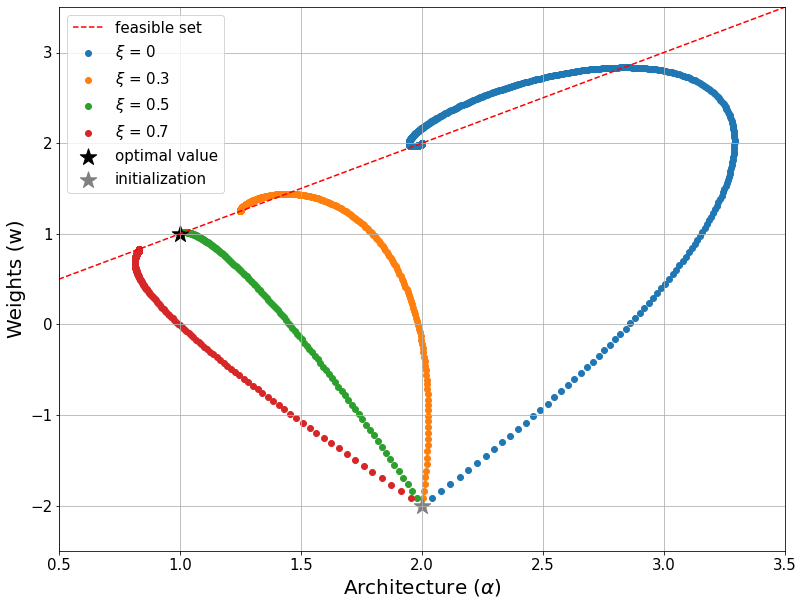

In [12]:
figsize(13, 10)

x = np.linspace(-5, 5, 100)
y = x
plot(x, y, '--', c='red', label='feasible set')

scatter(alpha_history_0, w_history_0, label='$\\xi$ = 0',)
scatter(alpha_history_03, w_history_03, label='$\\xi$ = 0.3')
scatter(alpha_history_05, w_history_05, label='$\\xi$ = 0.5')
scatter(alpha_history_07, w_history_07, label='$\\xi$ = 0.7')

scatter(alpha_star.item(), w_star.item(), marker='*', c='black', s=300, label='optimal value')
scatter(2, -2, c='grey', s=300, label='initialization', marker='*',)

grid()
legend(fontsize=15)
xlim(0.5, 3.5)
ylim(-2.5, 3.5)

xlabel('Architecture ($\\alpha$)', fontsize=20)
ylabel('Weights (w)', fontsize=20)

xticks(size=15)
yticks(size=15)

Time estimate

In [18]:
from time import time

In [44]:
start_time = time()
out1, out2 = train(num_iter=10000, xi=0, thr=1e-4, lr=1e-2)
end_time = time()
(end_time - start_time) / (len(out1) - 1)

  7%|▋         | 659/10000 [00:00<00:04, 2333.51it/s]


0.0004398406727722816

In [45]:
start_time = time()
out1, out2 = train(num_iter=10000, xi=0.3, thr=1e-4, lr=1e-2)
end_time = time()
(end_time - start_time) / (len(out1) - 1)

  4%|▍         | 411/10000 [00:00<00:08, 1127.60it/s]


0.0008968616634099733

In [46]:
start_time = time()
out1, out2 = train(num_iter=10000, xi=0.5, thr=1e-4, lr=1e-2)
end_time = time()
(end_time - start_time) / (len(out1) - 1)

  3%|▎         | 296/10000 [00:00<00:08, 1115.34it/s]


0.0009098785954552728

In [47]:
start_time = time()
out1, out2 = train(num_iter=10000, xi=0.7, thr=1e-4, lr=1e-2)
end_time = time()
(end_time - start_time) / (len(out1) - 1)

  3%|▎         | 335/10000 [00:00<00:08, 1134.69it/s]


0.0009311583504747989